## Physics Informed Neural Networks for Inverse Problems

In [1]:
from pinns import Pinns
from utils import *
import torch.optim as optim

Consider the one-dimensional heat equation:

$$
u_t(t, x) = k(t,x)u_{xx}(t, x) + s(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$

with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0,
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

The equation parameter $k:[0,T]\times[-1,1]\mapsto \mathbb{R} $ denotes the medium conductivity and $s:[0,T]\times[-1,1]\mapsto \mathbb{R}$ is a source term.

We want to solve a parameter identification inverse problem, which can be formulated as follows:

Given observation measurements of the medium temperature

$$
S_{meas}=\{(t_i, x_i, u^{meas}_{i})\}_{i=1}^{N_{meas}},
$$
find $u: [0,T]\times[-1,1]\mapsto\mathbb{R}$ and $k:[-1,1]\mapsto \mathbb{R}$, such that

$$u_t(t, x) = k(t,x)u_{xx}(t, x) + s(t,x),
\\ u_b(t, -1)=u_b(t,1)=0 \quad\text{   and  } \quad u(x, 0) = u_0(x) = -\sin(\pi x).$$






\\


To do so, we approximate the underlying solution and the medium conductivity with two feedforward dense neural network with tunable parameters $\theta$ and $\phi$:

$$
u_\theta(t,x) \approx u(t,x), \quad k_\phi(t, x) \approx k(t, x)
$$

We define the following residuals:

   - Interior residual given by,
   $$r_{int,\theta, \phi}(t, x):=  u_{\theta, t}(t, x) - k_\phi(t,x)u_{\theta, xx}(t, x) -s(t,x), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   

        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta, \phi) = \int_{[0,T]\times[-1,1]}r_{int,\theta, \phi}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad 1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences:

$$
L_{int}(\theta, \phi) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta,\phi}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

Also the measurements data $S_{meas}$ have to taken into account. To do so, we define ad additional loss term:
$$
L_{meas} = \frac{1}{N_{meas}}\sum_{i=1}^{N_{mean}}(u_\theta(t_i, x_i) - u^{meas}_i)^2(x_n)
$$
and eventually solve the following minimization problem

$$
\theta^\ast, \phi^\ast = argmin_{\theta, \phi} \Big(L_{int}(\theta, \phi) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta) + L_{meas}(\theta)
$$

\\

\\

\\

In the following let us assume

$$u_{ex}(t,x) = -\exp(-\pi^2 t)\sin(\pi x), \quad k(t,x)=k(x)=\sin(\pi x).$$

Then, the source term $s$ can be computed by plugging the expression above in the PDE:

$$
s(t,x) = -\pi^2u_{ex}(t,x)*(1 - k(t,x))
$$

Moreover, let us assume that the measurments data are given as follows:

$$
u_{meas}(x_i, t_i) = u_{ex}(x_i t_i) + 0.01\xi, \quad \xi \sim \mathcal{N(0, 1)}
$$

where $\mathcal{N(0, 1)}$ is a standard normal distribution.



Define *fit* function that takes model, num_epoch and optimizer as an input.

It runs the gradient descent and returns history of the loss computed at each epoch (using closure rule, as below).

Use the code below to plot the exact and the approximate solutions:

Let us test the code:




In [2]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)


############################
# TO DO: Once the training works, experiment with n_int, n_sb and n_tb
############################

n_int = 128
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

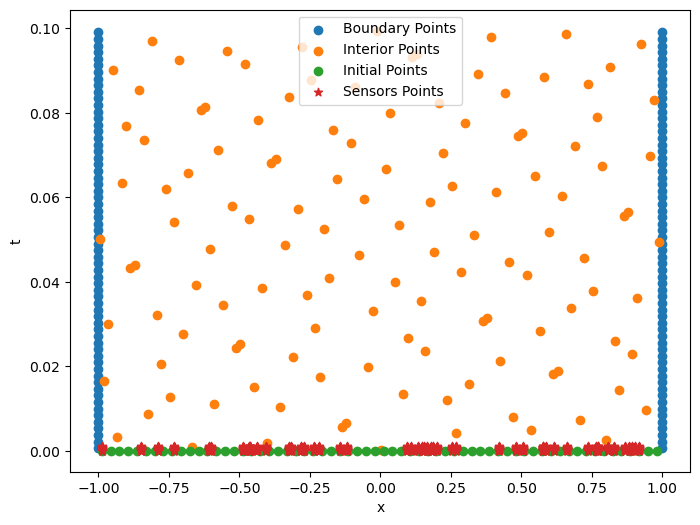

In [3]:
##############
# Define and plot the input training points

input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()
input_meas_, output_meas_ = pinn.get_measurement_data()

##############

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.scatter(input_meas_[:, 1].detach().numpy(), input_meas_[:, 0].detach().numpy(), label="Sensors Points", marker="*")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [4]:
n_epochs = 1
max_iter = 1000
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution.parameters()) + list(pinn.approximate_coefficient.parameters()),
                              lr=float(0.5),
                              max_iter=max_iter,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.005))

In [5]:
data  = pinn.training_set_sb

In [6]:
hist = fit(pinn,
          num_epochs=n_epochs,
          optimizer=optimizer_LBFGS,
          verbose=True)

################################  0  ################################
Total loss:  1.4496 | PDE Loss:  1.2134 | Function Loss:  0.0723
Total loss:  1.4404 | PDE Loss:  1.2128 | Function Loss:  0.0509
Total loss:  1.4106 | PDE Loss:  1.2098 | Function Loss:  -0.0211
Total loss:  1.3916 | PDE Loss:  1.2061 | Function Loss:  -0.0674
Total loss:  1.3729 | PDE Loss:  1.1994 | Function Loss:  -0.1094
Total loss:  1.3503 | PDE Loss:  1.1753 | Function Loss:  -0.1291
Total loss:  1.3388 | PDE Loss:  1.1484 | Function Loss:  -0.111
Total loss:  1.3165 | PDE Loss:  0.9855 | Function Loss:  0.0435
Total loss:  1.31 | PDE Loss:  1.0355 | Function Loss:  -0.0192
Total loss:  1.2749 | PDE Loss:  0.9201 | Function Loss:  0.0216
Total loss:  1.7716 | PDE Loss:  1.3153 | Function Loss:  0.5848
Total loss:  1.2429 | PDE Loss:  0.8433 | Function Loss:  0.0222
Total loss:  1.2184 | PDE Loss:  0.8194 | Function Loss:  -0.0027
Total loss:  1.1926 | PDE Loss:  0.7862 | Function Loss:  -0.0237
Total loss:  1.

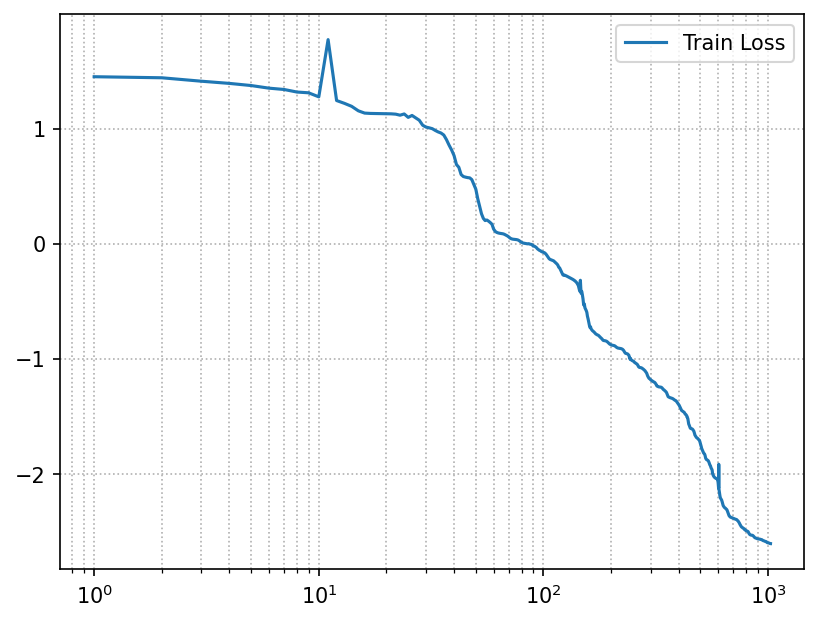

In [7]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

L2 Relative Error Norm U:  13.884777069091797 %
L2 Relative Error Norm K:  24.689098358154297 %


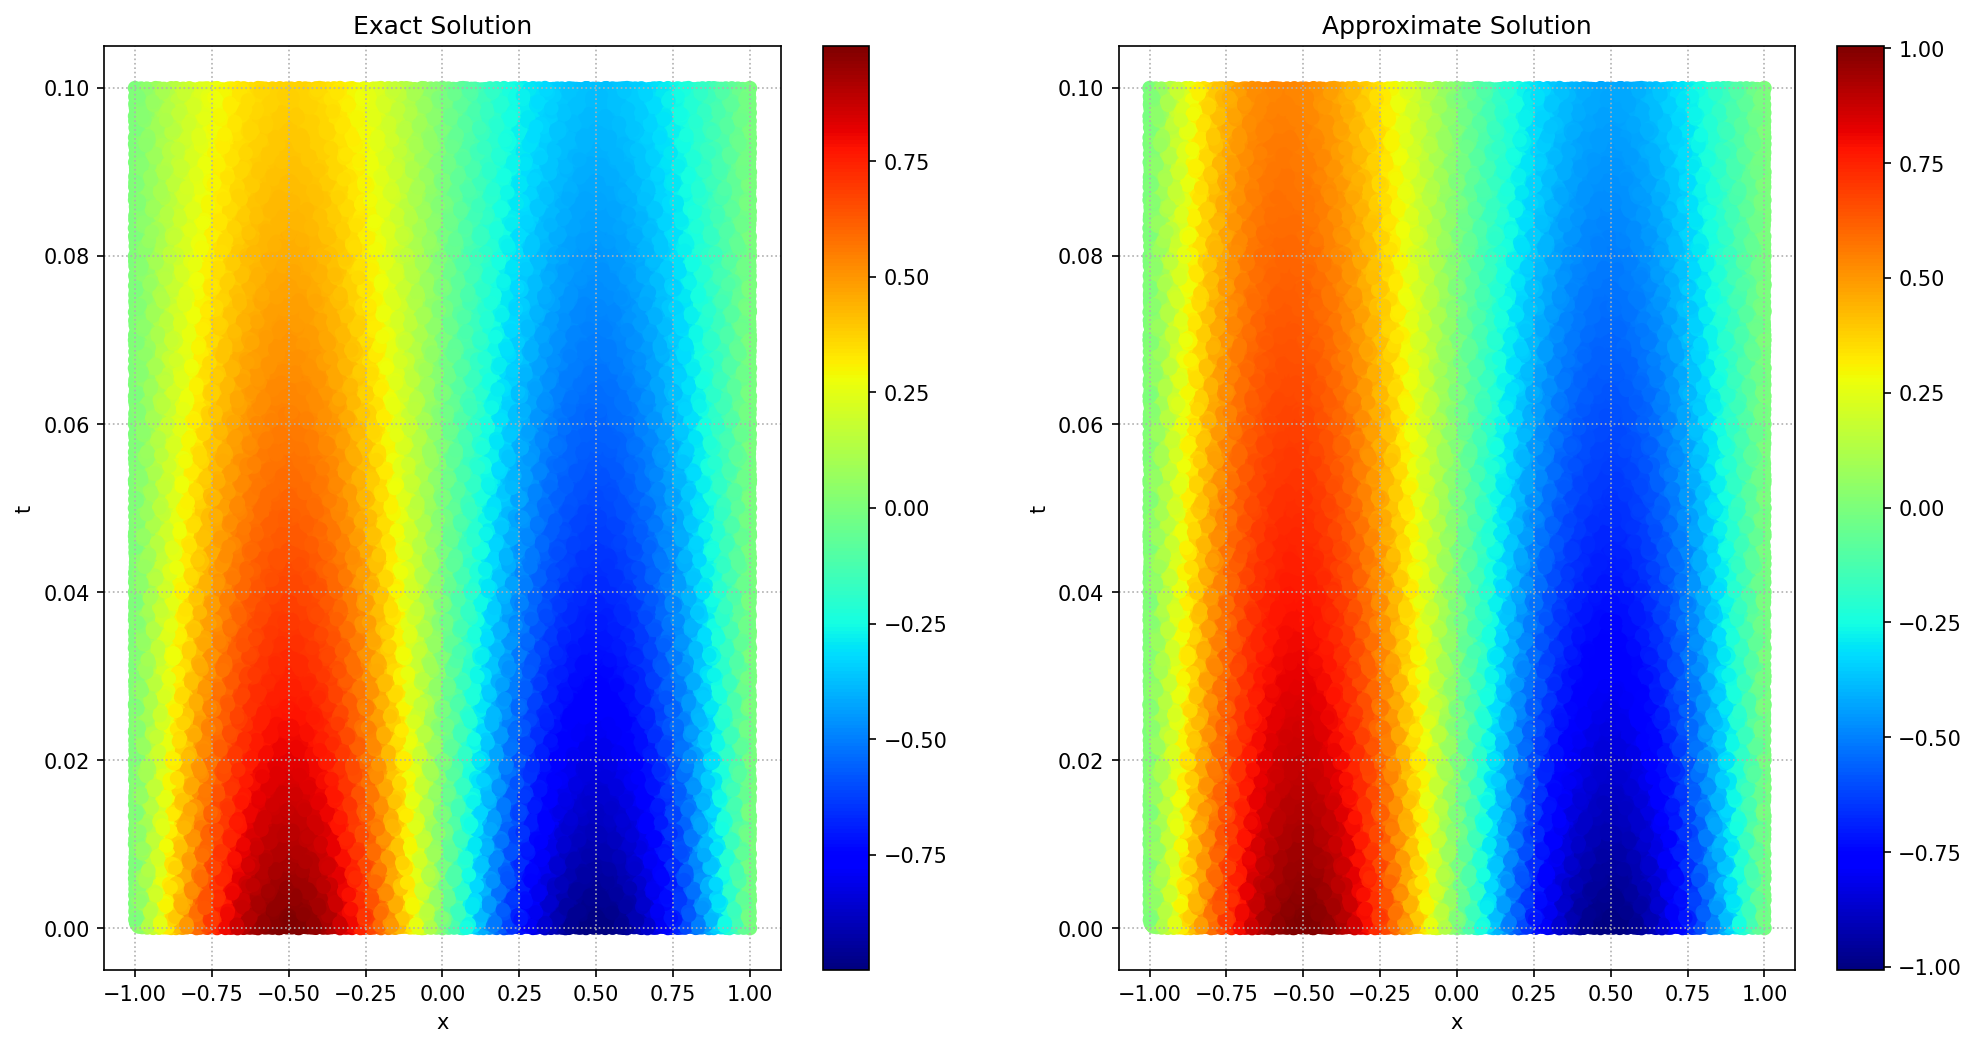

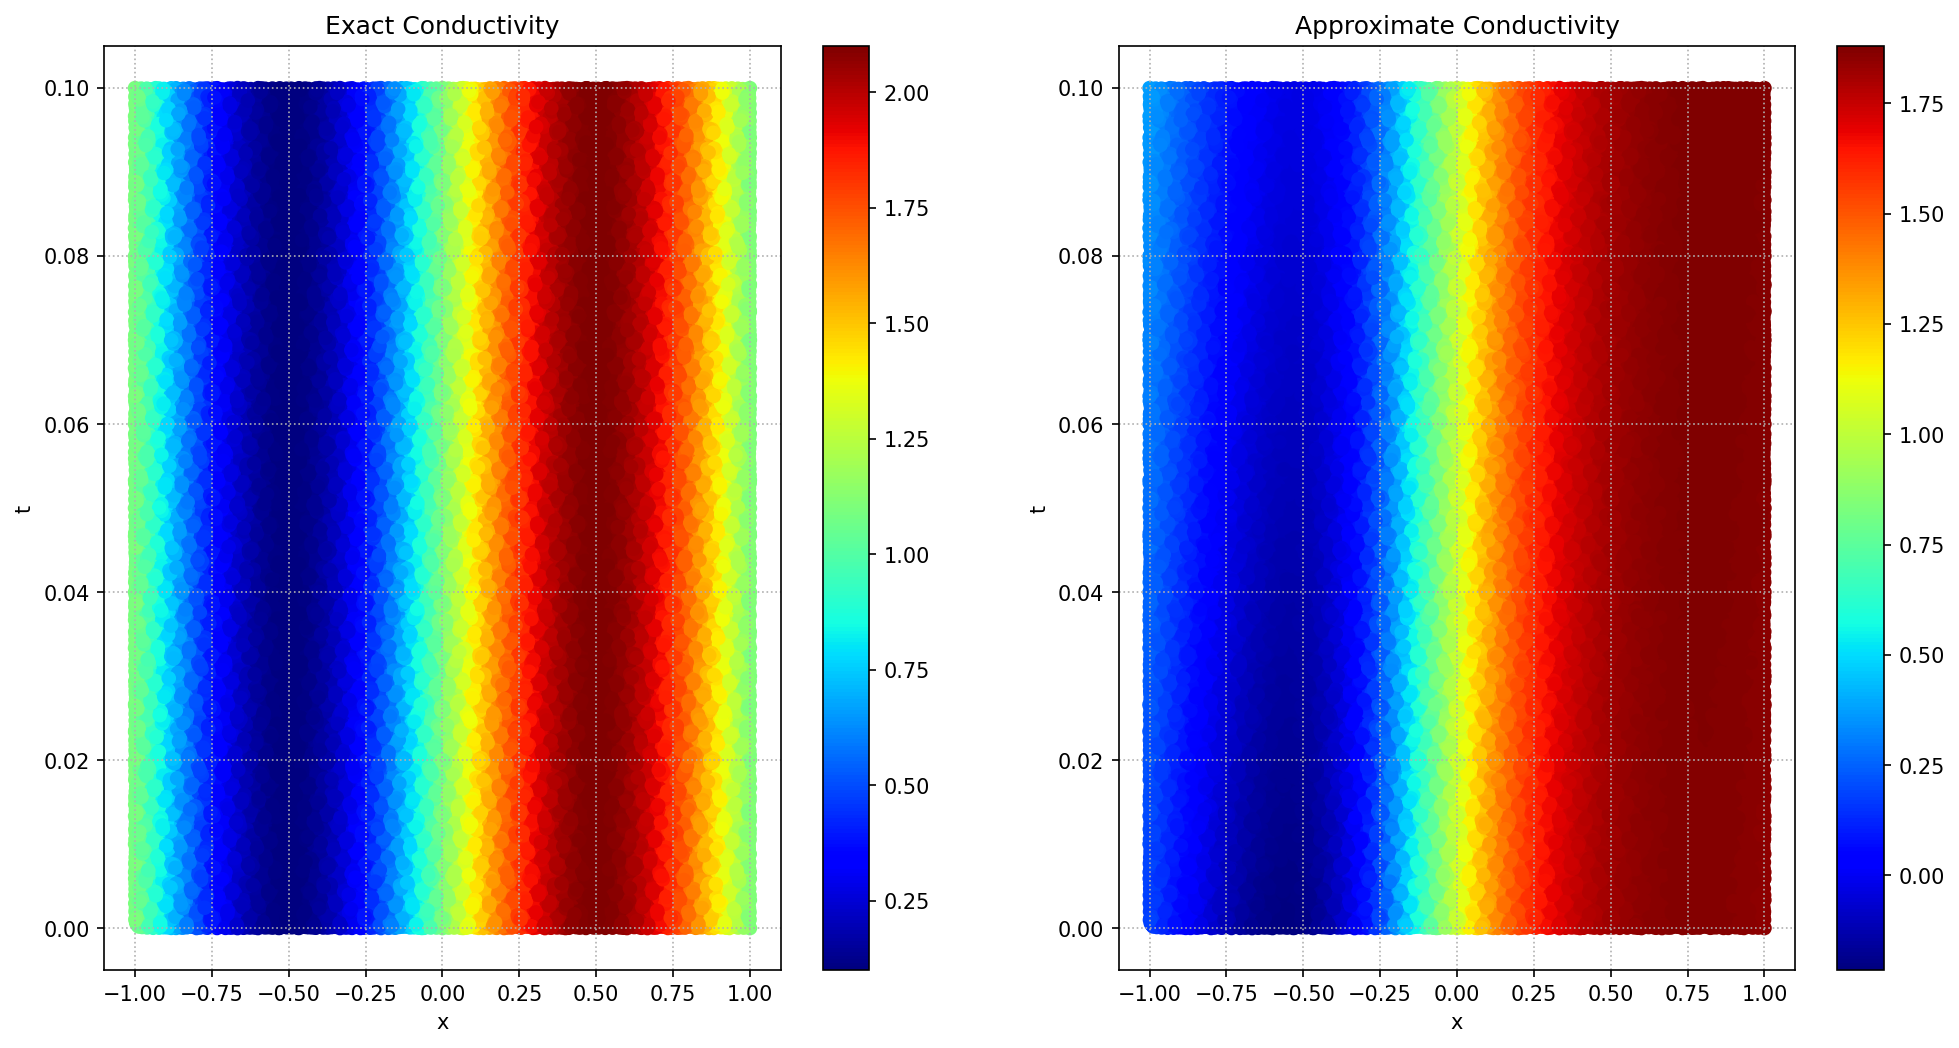

In [8]:
plotting(pinn)